<h1>Insurance Charges Analyzation and Prediction Model</h1>

<h3>Introduction</h3>

<p>This application will analyze patient data and explore trends between different patient demographics and their overall healthcare charges. The application will first load data and explore basic features, distributions, and correlations with charts and visualizations. After that, the applicatoin will split data into training and testing sets and develop a linear regression prediction model. This model will allow users to predict healthcare charges with patient demographics. A basic user interface will be available at the end of the application to allow users to input demographics and get charge predictions.</p>
<p>To get started, the application import all necessary libraries, tools, and functions.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
%matplotlib inline

Load dataset and display sample

In [2]:
raw_data = pd.read_csv('insurance.csv')
raw_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Get basic dataset information

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
raw_data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


<h3>Exploring Dataset</h3>

<p>The first figure shows that there is a fairly normal distribution of BMI levels among the patients.</p>

Text(0, 0.5, 'Patients')

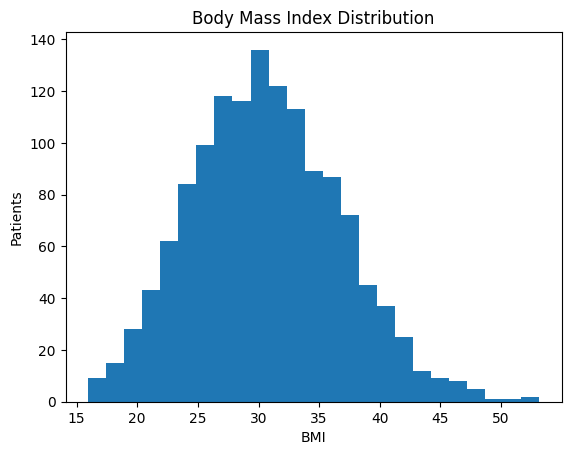

In [5]:
plt.hist(raw_data['bmi'], bins=25)
plt.title('Body Mass Index Distribution')
plt.xlabel('BMI')
plt.ylabel('Patients')

<p>The next histogram displays age distribution. It's clear that the data is skewed toward younger patients.</p>

Text(0, 0.5, 'Patients')

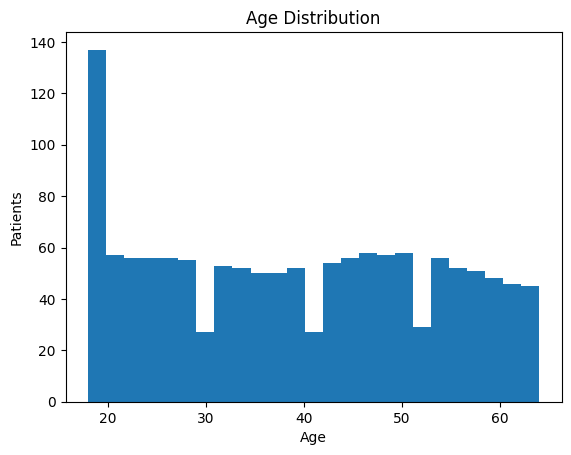

In [6]:
plt.hist(raw_data['age'], bins=25)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Patients')

<p>Now we compare categorical data with pie charts:</p>

Text(0.5, 1.0, 'Patients by Region')

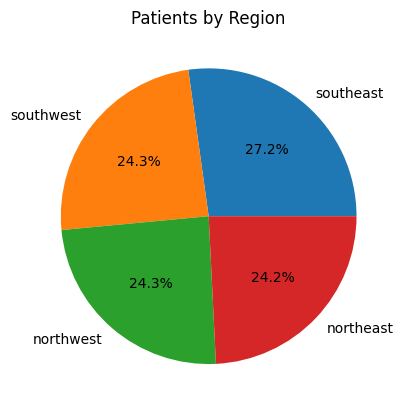

In [7]:
region_count = raw_data['region'].value_counts()
plt.pie(raw_data['region'].value_counts(), labels=region_count.index, autopct=lambda x: str(round(x, 1)) + '%')
plt.title('Patients by Region')

Text(0.5, 1.0, 'Patients with Children')

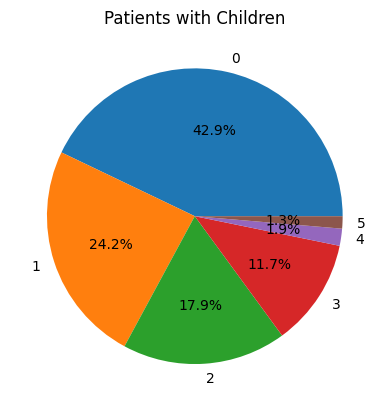

In [8]:
children_count = raw_data['children'].value_counts()
plt.pie(children_count, labels=children_count.index, autopct=lambda x: str(round(x, 1)) + '%')
plt.title('Patients with Children')

<p>Next we plot the relationship of age and bmi against charges. We also add a color key to explore the variance between smoker and non-smoker data. The data indicates a few things:</p>
<ul>
    <li>Smokers experience higher overall healthcare charges.</li>
    <li>There is a weak positive correlation between age and charges.</li>
    <li>There is a stronge positive correlation between bmi and charges for smokers.</li>
    <li>There doesn't appear to be any correlation between bmi and charges for non-smokers.</li>
</ul>

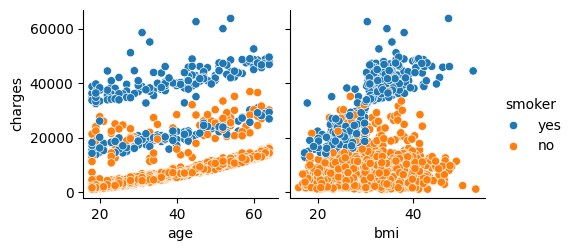

In [9]:
sns.pairplot(raw_data, x_vars=['age','bmi'], y_vars='charges', hue='smoker')

Text(0, 0.5, 'Patients')

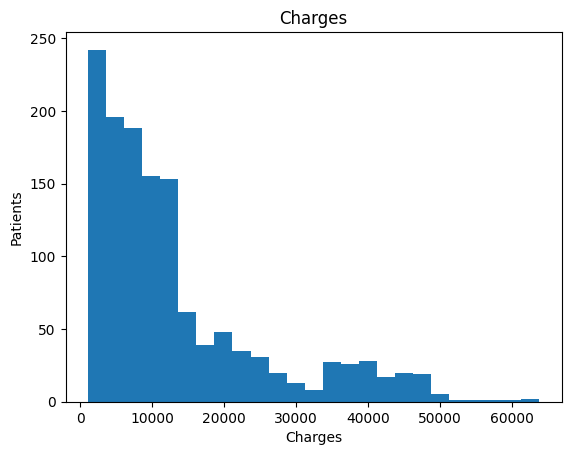

In [10]:
plt.hist(raw_data['charges'], bins=25)
plt.title('Charges')
plt.xlabel('Charges')
plt.ylabel('Patients')

<h3>Preparing and Formatting Dataset</h3>

<p>Since the application is using a linear regression model, all non-numerical data must be ignored or numerically formatted. We first create a new dataset by dropping the fields of 'region', 'sex', and 'smoker'. These fields are all non-numerical and cannot be used in to train the model. We then create a series of binary classification fields to signify this data in numerical format. Each of these new fields is added to the new dataset.</p>

In [11]:
new_data = raw_data.drop(['region','sex','smoker'], axis=1)

In [12]:
#Function to format category fields into binary field sets
def field_check(target, region):
    if region == target:
        return 1
    return 0

In [13]:
new_data['region_ne'] = raw_data['region'].apply(lambda x: field_check(x, 'northeast'))

In [14]:
new_data['region_se'] = raw_data['region'].apply(lambda x: field_check(x, 'southeast'))

In [15]:
new_data['region_sw'] = raw_data['region'].apply(lambda x: field_check(x, 'southwest'))

In [16]:
new_data['region_nw'] = raw_data['region'].apply(lambda x: field_check(x, 'northwest'))

In [17]:
new_data['sex'] = raw_data['sex'].apply(lambda x: field_check(x, 'male'))

In [18]:
new_data['smoker'] = raw_data['smoker'].apply(lambda x: field_check(x, 'yes'))

<p>A sample of the new formatted dataset is displayed below:</p>

In [19]:
new_data.head()

,age,bmi,children,charges,region_ne,region_se,region_sw,region_nw,sex,smoker
0,19,27.900,0,16884.92400,0,0,1,0,0,1
1,18,33.770,1,1725.55230,0,1,0,0,1,0
2,28,33.000,3,4449.46200,0,1,0,0,1,0
3,33,22.705,0,21984.47061,0,0,0,1,1,0
4,32,28.880,0,3866.85520,0,0,0,1,1,0


<h3>Training the Model</h3>

In [20]:
lm = LinearRegression()
X = new_data[['age','bmi','children','region_ne','region_se','region_sw','region_nw', 'sex', 'smoker']]
y = new_data['charges']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
lm.fit(X_train, y_train)

LinearRegression()

In [23]:
lm.coef_

array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02,  4.59585244e+02,
       -1.98279052e+02, -3.50214110e+02,  8.89079180e+01, -1.85916916e+01,
        2.36511289e+04])

<h3>Testing the Model</h3>

In [24]:
predictions = lm.predict(X_test)

<p>According to the prediction plot below, the model predicts charges slightly higher than the actual test data.</p>

Text(0, 0.5, 'Predicted')

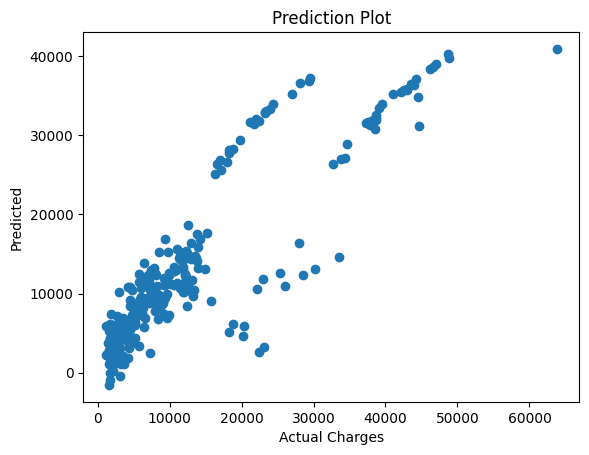

In [25]:
plt.scatter(y_test, predictions)
plt.title('Prediction Plot')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted')

<p>The model can be analyzed further through the following metrics:</p>
<ul>
    <li>Mean Absolute Error (MAE): The mean error between predicted and actual test values.</li>
    <li>Mean Squared Error (MSE): The mean of all errors squared. This value punishes large discrepancies more than MAE.</li>
    <li>Mean Root Error (MRE): Square root of mean squared error. Similar use to MSE but with the benefit of the value being measured in same units as data.</li>
</ul>

In [26]:
print("MAE: ", round(metrics.mean_absolute_error(y_test, predictions), 0))
print("MSE: ", round(metrics.mean_squared_error(y_test, predictions), 0))
print("MRE: ", round(np.sqrt(metrics.mean_squared_error(y_test, predictions)), 0))

MAE:  4181.0
MSE:  33596916.0
MRE:  5796.0


<p>Finally, the the R2 score will help us understand how well our model fits the dataset. The closer to 1 the score, the better. For our purposes a score above 0.75 will be suitable.</p>

In [27]:
print("R2: ", round(metrics.r2_score(y_test, predictions), 3))

R2:  0.784


<h2>User Input Setup</h2>

<p>The following class will provide an interface to allow a user to enter patient data and get a prediction:</p>

In [28]:
class Interface:
    #initialize with trained model
    def __init__(self, model):
        self.model = model

    def predict(self, age, sex, bmi, children, smoker, region):
        d = {'age':[age], 'bmi':[bmi], 'children':[children], 'region_ne':[], 'region_se':[], 'region_sw':[], 'region_nw':[], 'sex':[], 'smoker':[]}
        d['region_ne'].append(field_check(region, 'northeast'))
        d['region_se'].append(field_check(region, 'southeast'))
        d['region_sw'].append(field_check(region, 'southwest'))
        d['region_nw'].append(field_check(region, 'northwest'))
        d['sex'].append(field_check(sex, 'male'))
        d['smoker'].append(field_check(smoker, True))
        rec = pd.DataFrame(d)
        prediction = self.model.predict(rec)
        return "Predicted Charges: $" + str(round(prediction[0], 0))

In [29]:
ui = Interface(lm)

<h2>Widget Interface</h2>
<p>The following code will setup a simple user interface.</p>

In [30]:
import ipywidgets as widgets
from IPython.display import display

In [31]:
age_slider = widgets.IntSlider(
    value=18,
    min=18,
    max=100,
    description='Age:',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

In [32]:
bmi_box = widgets.BoundedFloatText(
    value=25.0,
    min=10.0,
    max=50.0,
    step=0.1,
    description='BMI:',
    disabled=False
)

In [33]:
children_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=20,
    description='Children',
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

In [34]:
smoker_box = widgets.Checkbox(
    value=False,
    description='Smoker',
    disabled=False
)

In [35]:
sex_selector = widgets.Dropdown(
    options=['male', 'female'],
    value='male',
    description='Sex:',
    disabled=False,
)


In [36]:
region_selector = widgets.Dropdown(
    options=['northeast', 'southeast', 'southwest', 'northwest'],
    value='northeast',
    description='Region:',
    disabled=False,
)

In [37]:
submit_btn = widgets.Button(
    description='Get Prediction',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Submit',
)

In [38]:
number_inputs = widgets.VBox([age_slider, children_slider, bmi_box])
selection_inputs = widgets.VBox([sex_selector, region_selector, smoker_box])
input_boxes = widgets.HBox([number_inputs, selection_inputs])
output = widgets.Output()

In [39]:
def on_button_click(btn):
    with output:
        output.clear_output()
        print(ui.predict(age=age_slider.value, sex=sex_selector.value, bmi=bmi_box.value, children=children_slider.value, smoker=smoker_box.value, region=region_selector.value))
submit_btn.on_click(on_button_click)

<h4>Make a Prediction:</h4>
<p>Try the model for yourself!</p>

In [40]:
display(input_boxes, submit_btn, output)

Button(description='Get Prediction', style=ButtonStyle(), tooltip='Submit')

Output()